# Time-integrated average 2-norm velocity gradient (sensitivity)

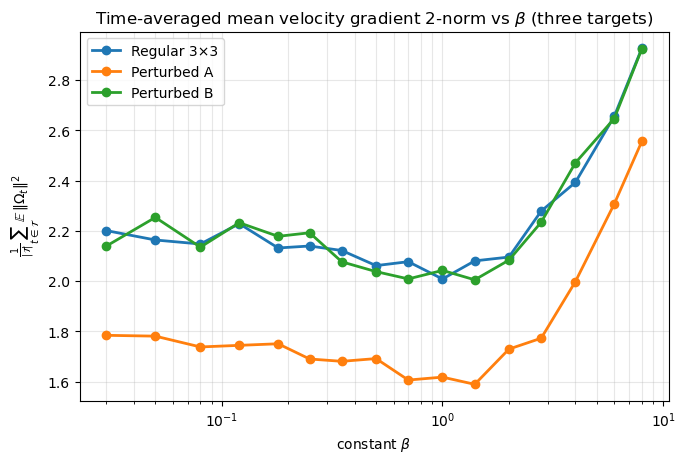

[saved] figs/three_models_avg_opnorm_vs_beta.png
[best β] Regular 3×3: β* ≈ 1, time-avg E||Ω_t||_2 ≈ 2.009
[best β] Perturbed A: β* ≈ 1.4, time-avg E||Ω_t||_2 ≈ 1.589
[best β] Perturbed B: β* ≈ 1.4, time-avg E||Ω_t||_2 ≈ 2.005


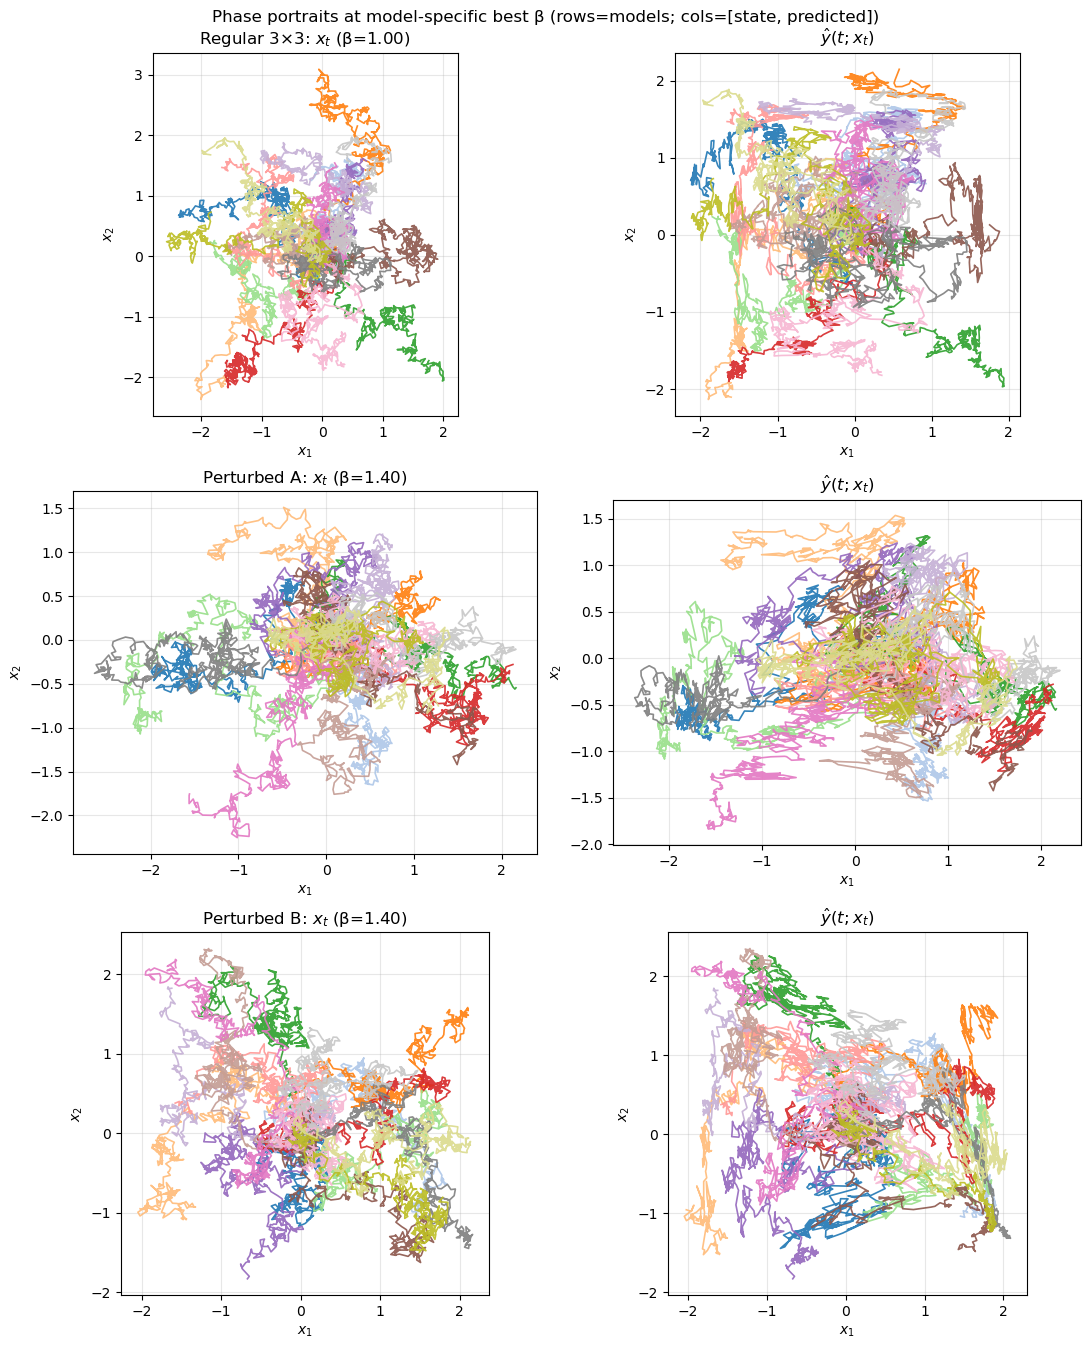

[saved] figs/three_models_phase_portraits_best_beta.png


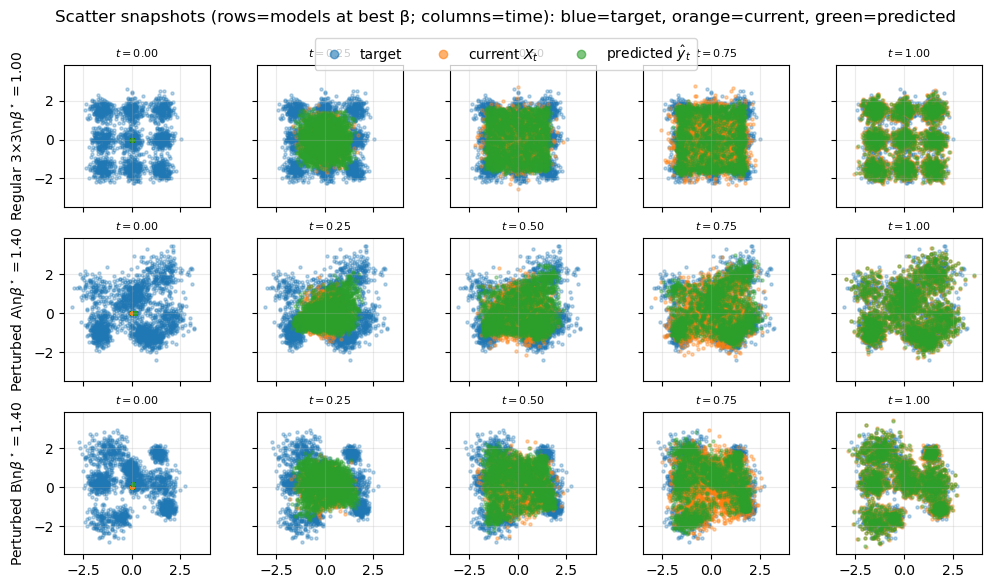

[saved] figs/three_models_snapshot_grid_best_beta.png


In [4]:
import numpy as np, math, os, time
import matplotlib.pyplot as plt
from ada_api_clean import *  # uses yhat_oracle_gmm, GMM, sample_gmm, regular, pertA, pertB

os.makedirs("figs", exist_ok=True)


# ============================================================
# Three-model study:
#   (A) Regular symmetric 3×3 GMM
#   (B) Perturbed instance #1 (jittered means, per-comp σ_k, non-uniform weights)
#   (C) Perturbed instance #2 (independent seed)
#
# Diagnostics:
#   1) β-sweep: time-averaged mean operator norm  E||Ω_t||_2  vs β  (all 3 models)
#   2) At each model’s best β (minimum of the curve):
#        • 3×2 phase portraits (rows=models; cols=[x_t paths, ŷ_t paths])
#        • 3×5 snapshot grid (rows=models; time slices across columns)
# Notes:
#   • Uses existing helpers from your “Ω_t stats” cell.
#   • Keeps isotropic per-component σ_k (matches current GMM / yhat_oracle_gmm API).
# ============================================================
import numpy as np, math, os
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

# ---------- Ω_t + radial sensitivities vs time ----------
def omega_stats_vs_time(sched, gmm, M=1200, T=800, seed=1, N_eval=24, Q_stat=400, eps_m=None):
    """
    Simulate once with midpoint EM, starting from X(0)=0.
    At N_eval midpoints spanning the *entire interior* (0,1), compute:
      • matrix stats of Ω_t = b^-·(∂ŷ/∂x) − a^-·I   on a random subset of Q_stat particles
      • radial (collinear) sensitivities means:
          \hatΩ_t^{∥} = v^T (∂ŷ/∂x) v,   v = x/||x||
          \tildeΩ_t^{∥} = (b^-/a^-) · \hatΩ_t^{∥}
          Ω_t^{∥} = b^-·\hatΩ_t^{∥} − a^-
    Returns dict with time grid and per-time means.
    """
    rng = np.random.default_rng(seed)
    dt = 1.0 / T
    d  = gmm.d
    X  = np.zeros((M, d), float)  # ENFORCE x(0)=0

    # choose N_eval evenly-spaced *interior* midpoints across n=0..T-1
    N_eval_eff = int(min(max(1, N_eval), T))
    t_idx = np.unique(np.linspace(0, T-1, N_eval_eff).round().astype(int))
    t_idx = np.clip(t_idx, 0, T-1)
    t_eval = (t_idx + 0.5) / T

    Q_stat = int(min(Q_stat, M))
    sub_idx = rng.choice(M, size=Q_stat, replace=False)

    mean_op   = np.empty(t_eval.size, float)
    mean_tr   = np.empty_like(mean_op)
    mean_lmax = np.empty_like(mean_op)
    mean_lmin = np.empty_like(mean_op)

    mean_Omega_par      = np.empty_like(mean_op)  # Ω_t^{∥}
    mean_Omegahat_par   = np.empty_like(mean_op)  # \hatΩ_t^{∥}
    mean_Omegatilde_par = np.empty_like(mean_op)  # \tildeΩ_t^{∥}

    # speed up membership checks
    t_idx_set = set(t_idx.tolist())
    k = 0
    for n in range(T):
        t = (n + 0.5) / T
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        if n in t_idx_set:
            X_sub = X[sub_idx, :]
            # Jacobian of predicted map and Ω_t
            J = jac_yhat_wrt_X_fd(X_sub, float(t), sched, gmm, eps_m=eps_m)   # (Q,d,d)
            I = np.eye(d)[None, :, :]
            Omega = b_m * J - a_m * I                                        # (Q,d,d)

            # matrix stats (Ω is ~symmetric numerically)
            evals = np.linalg.eigvalsh(Omega)        # (Q,d)
            opnorm = np.max(np.abs(evals), axis=1)   # ||Ω||_2
            mean_op[k]   = float(np.mean(opnorm))
            mean_tr[k]   = float(np.mean(np.sum(evals, axis=1)))
            mean_lmax[k] = float(np.mean(evals[:, -1]))
            mean_lmin[k] = float(np.mean(evals[:,  0]))

            # radial (collinear) sensitivities
            v = X_sub / (np.linalg.norm(X_sub, axis=1, keepdims=True) + 1e-12)  # (Q,d)
            # \hatΩ_t^{∥} = v^T J v
            Jv = np.einsum("qij,qj->qi", J, v)               # (Q,d)
            hat_par = np.einsum("qi,qi->q", Jv, v)           # (Q,)
            # \tildeΩ_t^{∥} = (b^-/a^-) · \hatΩ_t^{∥}
            if abs(a_m) > 1e-12:
                tilde_par = (b_m / a_m) * hat_par
            else:
                tilde_par = np.full_like(hat_par, np.nan)
            # Ω_t^{∥} = b^-·\hatΩ_t^{∥} − a^-
            Omega_par = b_m * hat_par - a_m

            mean_Omegahat_par[k]   = float(np.nanmean(hat_par))
            mean_Omegatilde_par[k] = float(np.nanmean(tilde_par))
            mean_Omega_par[k]      = float(np.nanmean(Omega_par))
            k += 1

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return {
        "t_eval": t_eval,
        "mean_op": mean_op, "mean_tr": mean_tr,
        "mean_lmax": mean_lmax, "mean_lmin": mean_lmin,
        "mean_Omega_par": mean_Omega_par,
        "mean_Omegahat_par": mean_Omegahat_par,
        "mean_Omegatilde_par": mean_Omegatilde_par,
    }

def jac_yhat_wrt_X_fd(X, t, sched, gmm, eps_m=None):
    """
    Central FD Jacobian of ŷ(t;X) wrt X via perturbing m=αX:
        ∂ŷ/∂X ≈ α [ŷ(m+ε e_i) - ŷ(m-ε e_i)] / (2ε) (col i).
    """
    X = np.asarray(X, float)
    Q, d = X.shape
    alpha, _, gamma = alpha_K_gamma_from_schedule(sched, float(t))
    alpha = float(alpha)
    if not np.isfinite(alpha) or abs(alpha) < 1e-12:
        raise RuntimeError(f"alpha(t) ill-conditioned at t={t}: {alpha}")
    if eps_m is None:
        eps_m = 1e-3 * max(float(gamma), 1e-2)

    J  = np.zeros((Q, d, d), float)
    dX = eps_m / alpha
    for i in range(d):
        Xp = X.copy(); Xp[:, i] += dX
        Xm = X.copy(); Xm[:, i] -= dX
        Yp = yhat_oracle_gmm(Xp, float(t), sched, gmm)
        Ym = yhat_oracle_gmm(Xm, float(t), sched, gmm)
        col = (Yp - Ym) / (2.0 * eps_m)
        J[:, :, i] = alpha * col
    return J

# ---------- phase diagrams (x(0)=0) ----------
def simulate_and_collect_for_phase(sched, gmm, M=400, T=600, seed=0, P_show=20):
    rng = np.random.default_rng(seed)
    dt = 1.0 / T
    d  = gmm.d
    X  = np.zeros((M, d), float)  # ENFORCE x(0)=0

    P_show = min(P_show, M)
    idx = rng.choice(M, size=P_show, replace=False)
    X_show  = np.empty((P_show, T, d), float)
    Yh_show = np.empty_like(X_show)

    for n in range(T):
        t = (n + 0.5) / T
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        X_show[:, n, :]  = X[idx, :]
        Yh_show[:, n, :] = yhat[idx, :]

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return X_show, Yh_show

def plot_phase_diagram(X_traj, Yh_traj, title, fname):
    P, T, d = X_traj.shape
    assert d == 2, "Phase diagram expects 2D state for plotting."
    cmap = plt.cm.tab20
    cols = [cmap(i % 20) for i in range(P)]

    fig, axs = plt.subplots(1, 2, figsize=(10.8, 4.8), constrained_layout=True)
    for p in range(P):
        axs[0].plot(X_traj[p,:,0],  X_traj[p,:,1],  lw=1.2, alpha=0.9, color=cols[p])
        axs[1].plot(Yh_traj[p,:,0], Yh_traj[p,:,1], lw=1.2, alpha=0.9, color=cols[p])

    for ax, name in zip(axs, ["$x_t$ (state paths)", r"$\hat{x}_t=\hat{y}(t;x_t)$ (predicted)"]):
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, alpha=0.3); ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
        ax.set_title(name)

    fig.suptitle(title)
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()
    print("[saved] {}".format(fname))



# ---------------------------- model builders ----------------------------

def build_perturbed_gmm(seed, a=1.5, base_sigma=0.3,
                        jitter_frac=1/3, sig_scale=(0.5, 2.0),
                        weight_range=(0.5, 1.5)):
    rng = np.random.default_rng(int(seed))
    xs = np.array([-a, 0.0, a], float)
    centers = np.array([[xi, yj] for yj in xs for xi in xs], float)  # (9, 2)
    jitter_max = a * float(jitter_frac)
    MU  = centers + rng.uniform(-jitter_max, jitter_max, size=centers.shape)
    SIG = base_sigma * rng.uniform(sig_scale[0], sig_scale[1], size=9)  # per-comp σ_k > 0
    w   = rng.uniform(weight_range[0], weight_range[1], size=9)
    PI  = w / np.sum(w)
    return GMM(MU, SIG, PI)

# ---------------------------- helpers (small wrappers) ----------------------------
def time_avg_mean_opnorm_for_model(gmm_model, beta_grid, M=1500, T=900, seed=1234,
                                   N_eval=24, Q_stat=400):
    """Return β-grid and time-averaged mean operator norms for constant-β schedules."""
    avg = []
    for b in beta_grid:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)  # health probe
        summ = omega_stats_vs_time(
            sched, gmm_model, M=M, T=T, seed=seed + int(31*b),
            N_eval=N_eval, Q_stat=Q_stat, eps_m=None
        )
        avg.append(float(np.mean(summ["mean_op"])))
    return np.asarray(beta_grid, float), np.asarray(avg, float)

def argmin_beta(beta, vals):
    j = int(np.nanargmin(vals))
    return float(beta[j]), float(vals[j])

# Make sure snapshot simulator exists (from your previous “NEW (2)” block)
try:
    simulate_snapshots_const_beta
except NameError:
    def simulate_snapshots_const_beta(sched, gmm, M=1500, T=600, seed=1234, N_cols=5, t_floor=0.01):
        rng  = np.random.default_rng(seed)
        dt   = 1.0 / T
        d    = gmm.d
        X    = np.zeros((M, d), float)
        idx  = np.linspace(0, T-1, N_cols).round().astype(int)
        ptr  = 0
        times = []; snaps_X = []; snaps_Yh = []
        for n in range(T):
            t_mid = (n + 0.5) / T
            t_eff = min(max(t_mid, float(t_floor)), 1.0 - float(t_floor))
            yhat  = yhat_oracle_gmm(X, float(t_eff), sched, gmm)
            a_m   = float(sched.a_minus(float(t_eff)))
            b_m   = float(sched.b_minus(float(t_eff)))
            u     = b_m * yhat - a_m * X
            if ptr < len(idx) and n == idx[ptr]:
                times.append(t_mid); snaps_X.append(X.copy()); snaps_Yh.append(yhat.copy()); ptr += 1
            dW = rng.normal(size=X.shape) * math.sqrt(dt)
            X  = X + u*dt + dW
        return np.array(times, float), snaps_X, snaps_Yh

# ---------------------------- construct three models ----------------------------
models = [
    ("Regular 3×3", regular),
    ("Perturbed A",  pertA),
    ("Perturbed B",  pertB),
]

# ---------------------------- β-grid & runtime knobs ----------------------------
# Dense near β≈1; log-ish spread
beta_grid = np.array([0.03, 0.05, 0.08, 0.12, 0.18, 0.25, 0.35, 0.5, 0.7, 1.0,
                      1.4, 2.0, 2.8, 4.0, 6.0, 8.0], float)

# Sizes for the Ω_t sweep (adjust if you want faster/slower)
M_sweep, T_sweep = 200, 500
N_eval, Q_stat   = 200, 350
seed_sweep_base  = 20241007

# ---------------------------- sweep: time-avg E||Ω_t||_2 vs β ----------------------------
curves = {}
for i, (name, gmm_model) in enumerate(models):
    b, v = time_avg_mean_opnorm_for_model(
        gmm_model, beta_grid, M=M_sweep, T=T_sweep,
        seed=seed_sweep_base + 100*i, N_eval=N_eval, Q_stat=Q_stat
    )
    curves[name] = {"beta": b, "avg_op": v, "gmm": gmm_model}

# plot all three curves on one figure
plt.figure(figsize=(7.6, 4.8))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, (name, info) in enumerate(curves.items()):
    plt.plot(info["beta"], info["avg_op"], marker="o", lw=2.0, color=colors[i%len(colors)], label=name)
plt.xscale("log")
plt.xlabel(r"constant $\beta$")
plt.ylabel(r"$\;\frac{1}{|\mathcal{T}|}\sum_{t\in\mathcal{T}} \mathbb{E}\,\|\Omega_t\|^2$")
plt.title(r"Time-averaged mean velocity gradient 2-norm vs $\beta$ (three targets)")
plt.grid(True, which="both", alpha=0.3)
plt.legend(frameon=True)
fname_curve = "figs/three_models_avg_opnorm_vs_beta.png"
plt.savefig(fname_curve, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fname_curve)

# pick best β (minimum) per model
best = {}
for i, (name, info) in enumerate(curves.items()):
    b_opt, v_opt = argmin_beta(info["beta"], info["avg_op"])
    best[name] = {"beta": b_opt, "avg": v_opt, "gmm": info["gmm"]}
    print(f"[best β] {name}: β* ≈ {b_opt:.3g}, time-avg E||Ω_t||_2 ≈ {v_opt:.4g}")

# ---------------------------- phase portraits at each model’s best β ----------------------------
# Sim sizes for phase portraits
M_phase, T_phase, seed_phase = 2000, 500, 20241008

# collect trajectories per model at its best β
phase_data = []
for i, (name, rec) in enumerate(best.items()):
    gmm_model = rec["gmm"]; b = rec["beta"]
    sched = BetaSchedulePWC.constant(float(b))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)
    Xtraj, Yhtraj = simulate_and_collect_for_phase(
        sched, gmm_model, M=M_phase, T=T_phase, seed=seed_phase + 37*i, P_show=18
    )
    phase_data.append((name, b, Xtraj, Yhtraj))

# plot as one 3×2 figure (rows=models; columns=[x_t paths, ŷ_t paths])
fig, axs = plt.subplots(len(phase_data), 2, figsize=(10.8, 4.4*len(phase_data)),
                        constrained_layout=True)
if len(phase_data) == 1:
    axs = np.array([axs])
for i, (name, b, Xtraj, Yhtraj) in enumerate(phase_data):
    P, T, d = Xtraj.shape
    cmap = plt.cm.tab20
    cols = [cmap(k % 20) for k in range(P)]
    # left: x_t
    axL = axs[i, 0]
    for p in range(P):
        axL.plot(Xtraj[p,:,0], Xtraj[p,:,1], lw=1.2, alpha=0.9, color=cols[p])
    axL.set_aspect("equal", adjustable="box"); axL.grid(True, alpha=0.3)
    axL.set_title(fr"{name}: $x_t$ (β={b:.2f})"); axL.set_xlabel("$x_1$"); axL.set_ylabel("$x_2$")
    # right: ŷ_t
    axR = axs[i, 1]
    for p in range(P):
        axR.plot(Yhtraj[p,:,0], Yhtraj[p,:,1], lw=1.2, alpha=0.9, color=cols[p])
    axR.set_aspect("equal", adjustable="box"); axR.grid(True, alpha=0.3)
    axR.set_title(r"$\hat{y}(t;x_t)$"); axR.set_xlabel("$x_1$"); axR.set_ylabel("$x_2$")

fig.suptitle("Phase portraits at model-specific best β (rows=models; cols=[state, predicted])", y=1.01)
fname_phase = "figs/three_models_phase_portraits_best_beta.png"
fig.savefig(fname_phase, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fname_phase)

# ---------------------------- snapshot scatter grid (3 rows × 5 cols) ----------------------------
# Settings
M_snap, T_snap, seed_snap = 2000, 500, 20241009
N_cols = 5
green = "#2ca02c"

# Collect snapshots and CRN target samples per model
snap_results = []
XY_all = []   # to set shared axis limits across the whole figure
for i, (name, rec) in enumerate(best.items()):
    gmm_model = rec["gmm"]; b = rec["beta"]
    # CRN target samples
    rngY = np.random.default_rng(seed_snap + 791*i)
    Y_ref, _ = sample_gmm(gmm_model, M_snap, rngY)
    # simulate and collect 5 time slices
    sched = BetaSchedulePWC.constant(float(b))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)
    times, X_list, Yh_list = simulate_snapshots_const_beta(
        sched, gmm_model, M=M_snap, T=T_snap, seed=seed_snap + 17*i, N_cols=N_cols, t_floor=0.01
    )
    snap_results.append((name, b, Y_ref, times, X_list, Yh_list))
    XY_all.append(Y_ref)
    for arr in X_list:  XY_all.append(arr)
    for arr in Yh_list: XY_all.append(arr)

# Shared axis limits
XY_all = np.vstack(XY_all)
xmin, ymin = XY_all.min(axis=0); xmax, ymax = XY_all.max(axis=0)
padx = 0.06*(xmax - xmin + 1e-9); pady = 0.06*(ymax - ymin + 1e-9)
xlim = (xmin - padx, xmax + padx); ylim = (ymin - pady, ymax + pady)

# Plot 3×5 grid
fig, axs = plt.subplots(len(snap_results), N_cols,
                        figsize=(2.0*N_cols, 1.8*len(snap_results)),
                        sharex=True, sharey=True, constrained_layout=True)
if len(snap_results) == 1:
    axs = np.array([axs])

for i, (name, b, Y_ref, times, X_list, Yh_list) in enumerate(snap_results):
    for j in range(N_cols):
        ax = axs[i, j]
        ax.scatter(Y_ref[:,0], Y_ref[:,1], s=5, alpha=0.30, color="C0", label="target" if (i==0 and j==0) else None)
        ax.scatter(X_list[j][:,0],  X_list[j][:,1],  s=5, alpha=0.35, color="C1", label="current" if (i==0 and j==0) else None)
        ax.scatter(Yh_list[j][:,0], Yh_list[j][:,1], s=5, alpha=0.35, color=green,  label="predicted" if (i==0 and j==0) else None)
        ax.set_aspect("equal", adjustable="box"); ax.grid(True, alpha=0.25)
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        ax.set_title(fr"$t={times[j]:.2f}$", fontsize=8)
        if j == 0:
            ax.set_ylabel(fr"{name}\n$\beta^\star={b:.2f}$", rotation=90)

handles = [
    plt.Line2D([0],[0], marker="o", linestyle="", color="C0", alpha=0.6, label="target"),
    plt.Line2D([0],[0], marker="o", linestyle="", color="C1", alpha=0.6, label="current $X_t$"),
    plt.Line2D([0],[0], marker="o", linestyle="", color=green, alpha=0.6, label="predicted $\hat y_t$"),
]
fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=True)
fig.suptitle("Scatter snapshots (rows=models at best β; columns=time): blue=target, orange=current, green=predicted", y=1.06)

fname_snap = "figs/three_models_snapshot_grid_best_beta.png"
fig.savefig(fname_snap, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fname_snap)
